# Transformation of probabilities: measurement uncertainties in flux and magnitudes #

**WIC** - Originally edited out of some stats notebooks originally written for the UM-D ASTR research group. Notes somewhat sparse.

**Notes to students:** 

The plotting cells are somewhat complicated (although each of the lines I think is reasonably straightforward) to ensure that I show exactly what I want to show.

Don't worry about understanding every line in the routines below. You should however experiment with them, there are some fairly clear signposts on how to do this, particularly in Section 3 below.

## 0. Introduction ##

Often you might have some parameter on which you have a measurement $\hat{\theta}$ and an uncertainty $\sigma(\theta)$, but for various reasons you want to know the error on some transformed value $\phi = g(\theta)$. If you know $\sigma(\theta)$, what is $\sigma (g(\theta)) = \sigma(\phi)$? What does $\sigma(\phi)$ even mean?

(Notation alert: As a shorthand, I'll refer to the differences between the "measured" values and the "true" values as the "residuals." Here and throughout, I use the "error" or "uncertainty" $\sigma$ to report the expected size of the residuals, and will usually calculate it as the standard deviation of the residuals.) 

An example might be astronomical magnitudes. Your CCD detector (which essentially counts the number of photons incident on each pixel) most naturally leads to estimates of "flux" (power per unit time per unit area entering the telescope aperture from the object). However since the dynamic range of brightnesses in the sky is so large, astronomers tend to report measurements in astronomical apparent magnitudes, defined as
\begin{eqnarray}
    m & = & -2.5 \log_{10}\left(\frac{f}{f_0}\right) \\
    & = & -2.5 \log_{10}(f) + ZPT
\end{eqnarray}
where $f$ and $f_0$ are the from the target and a standard reference source, respectively. The second form is identical, with "ZPT" being a suitably defined zeropoint.

Clearly, if you have an estimate for the flux $f$ in your CCD image, and an associated uncertainty estimate $f \pm \sigma(f)$, then when reporting the associated magnitude $m \pm \sigma(m)$, you need to know how to accurately report $\sigma(m)$.



### 0.1 Here be dragons! ###

This is where things get interesting. Not only will the value of $\sigma(\phi)$ differ from $\sigma(\theta)$, but the *distribution* of the residuals may well be different as well. We'll illustrate this in sections 1-3.

Your measured quantity $\theta$ might show residuals that are Gaussian (you might have sanded off the edges with the Central Limit Theorem by averaging lots of datapoints), so that $\sigma(\theta)$ completely describes the shape of the residuals about $\hat{\theta}$. Once transformed, however, the residuals in $\phi = g(\theta)$ will in many cases differ from Gaussian, and can be highly asymmetric. In the example $\theta$=flux and $\phi$=magnitudes above, this is likely, as you'll see below.

Because the distributions of $\theta$ and $\phi$ residuals differ, interpretation of $\sigma(\phi)$ can be complicated. In this case, does a single number $\sigma(\phi)$ convey enough information to accurately make inferences about the distribution of $\phi$ values consistent with your data?



### 0.2. Making progress: uncertainty propagation ###

Even within the Maximum Likelihood framework (i.e. not worrying about priors, which also transform (don't worry if you haven't seen these last two terms before)), we therefore have to be a bit careful on how we proceed. Two methods:

(i) * **Analytical approximation:** * If you've done a lab course at the 300+ level, you've probably seen some analytical expressions for uncertainty propagation. These are **highly** useful for rough estimates, and as long as your uncertainties are "small enough," they give accurate results. Here's the one relevant for this Notebook: if $\phi$ is a function of a single variable $\theta$, then
\begin{equation}
    \sigma(\phi) \approx \left| \frac{dg}{d\theta} \right| \sigma(\theta)
\end{equation}

(For example, if $\phi = 10.0 -4 \theta^2$, then $\sigma(\phi) = 8\theta \sigma(\theta)$, etc...)

Returning to our astronomical example: if $\theta = f$ and $\phi = m = -2.5\log_{10}(f) + ZPT$ as above, you can derive $\sigma(m)$.

(ii) * **Uncertainty by Monte Carlo** *  Under the model you might have for the residuals in $\theta$, you simulate a large number of residuals, transform the measurements through to $\phi$-space, and evaluate the distribution in $\phi$ values that result. 

**Uncertainty by Monte Carlo is my preferred technique.** This gives you not only the size of $\sigma(\phi)$, but you also get the distribution of residuals in $\phi$, and can report the distribution in your preferred manner. 

(There is a growing number of Astronomers who are advocating for derived parameters to be reported not as $\phi \pm\sigma(\phi)$ - which as you see in section 1 hides the true distribution of $\hat{\phi}$ - but to report the distribution (possibly as a callable function). This is generally very hard to do for method (i) above except in special cases). 



Approach (ii) above is what we do here in this Notebook. This gives you a framework to accurately propagate the value and distribution of uncertainty in transformed space. You don't even need the distribution of residuals in $\theta$ to be Gaussian - just simulate what you have and send it through.

Along the way, we'll be able to set quite precise limits on where approach (i) is valid, and where it starts to seriously mis-predict (usually underestimating) the true uncertainty in $\phi$.

** *This is much more powerful than the analytic technique* **, at the cost of computing time (which is cheap). In reasonably complicated cases (like multiple variables which are correlated), it's usually a *much* better use of your time to estimate uncertainty by Monte Carlo than to slog through the analytic uncertainty propagation. 

(Note: we'll also include some censoring; we'll suppose that the residuals follow the parent distribution even if this makes the resulting flux value negative, but that negative values are never measured by the equipment).



### 0.3 Importing a few things we'll need ###

In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from scipy import stats
from scipy import interpolate
import time

In [2]:
# Snazzy R-type plot style
blah=0
try:
    plt.style.use('ggplot')
except:
    blah = 1

In [3]:
%matplotlib inline

In [4]:
npoints = 500000

In [5]:
def Gauss1d(x, mu=0., sigma=1.):
    rscal = (x - mu)/sigma
    return 1.0/(sigma*np.sqrt(2.0*np.pi)) * np.exp(-0.5*rscal**2)

## 1. Transforming flux to magnitudes ##

### 1.1. What happens to the distribution of residuals?###

In [6]:
# Generate gaussian-distributed flux values, transform to magnitudes, 
# evaluate the stddev and skewness of the fluxes and magnitudes.

If you've not heard of Skewness and Kurtosis before: they are statistics related to the third and fourth moments of the data respectively, that provide information on the degree of asymmetry (Skewness) and the degree of central concentration compared to a Gaussian (Kurtosis). Many programming languages have Skewness and Kurtosis routines built in.

For the functional form, along with more discussion, see 

http://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm

In [7]:
# Set the "true" flux value and the stddev of the residuals about 
# this value.
medn = 20.
sdev = 8. # Use 6.0 or more for this to handle asymmetric errors.

In [8]:
# Generate "fluxes"
fl = np.random.normal(size=npoints)*sdev + medn
g = np.where(fl > 0)[0]
fl = fl[g]

# Compute "magnitudes" 
#zpt = 0. # if flux were absolutely calibrated
zpt = +2.5*np.log10(np.median(fl)) # flux ratio of midpoint flux
mag = -2.5*np.log10(fl) + zpt

# Compute the variance and the skew
fluxMoments = np.zeros(2)
magnMoments = np.copy(fluxMoments)

fluxMoments[0] = np.std(fl)
fluxMoments[1] = stats.skew(fl)

magnMoments[0] = np.std(mag)
magnMoments[1] = stats.skew(mag)

print "Skewness(flux) %.4f; Skewness(mag) %.4f"  % (fluxMoments[1], magnMoments[1])

Skewness(flux) 0.1011; Skewness(mag) 2.3181


If you had sdevn/med $\gtrsim$ 0.2 or so, the right-hand histogram looks fairly skewed. 

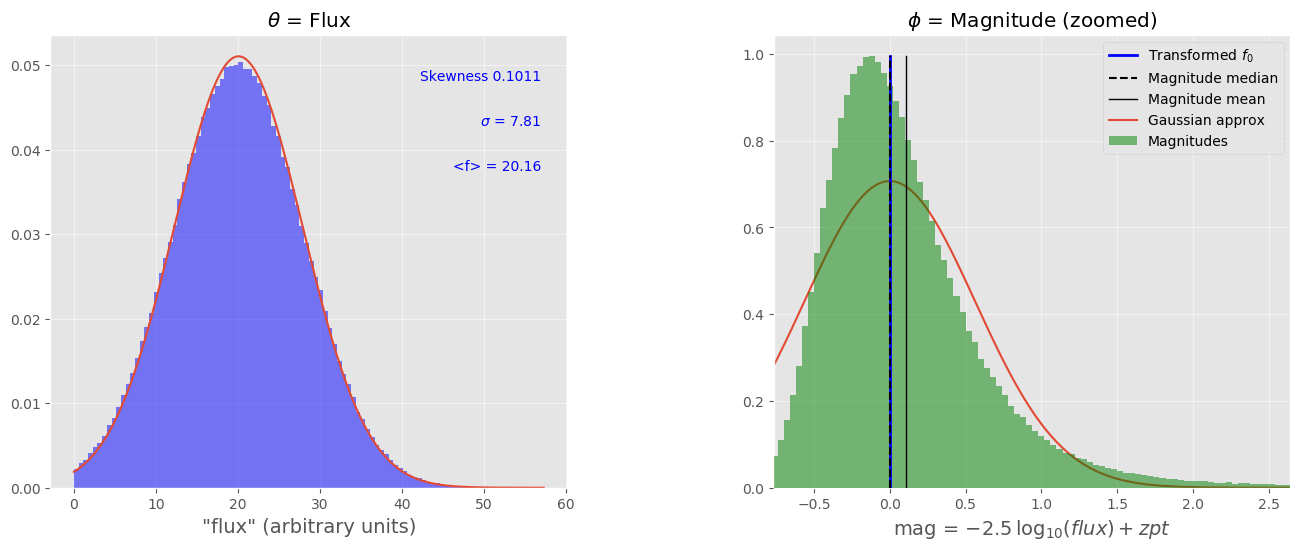

In [9]:
plt.figure(1, figsize=(16,6))
plt.clf()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.subplot(121)

# actually return the bins too
nBinsFlux = 100
nBinsMag = 300

nFlux, edgesFlux, patchesFlux = plt.hist(fl, bins=nBinsFlux, \
                                         alpha=0.5, normed=True, color='b')
plt.xlabel('"flux" (arbitrary units)', fontsize=14)
plt.grid(which='both', alpha=0.5, zorder=30)

plt.annotate('<f> = %.2f' % (np.mean(fl)), (0.95,0.70), \
             color='b', xycoords='axes fraction', ha='right')


plt.annotate('$\sigma$ = %.2f' % (fluxMoments[0]), (0.95,0.80), \
             color='b', xycoords='axes fraction', ha='right')

plt.annotate('Skewness %.4f' % (fluxMoments[1]), (0.95,0.90), \
             color='b', xycoords='axes fraction', ha='right')

# Let's overplot a gaussian again
xFine = np.linspace(np.min(fl), np.max(fl), num=1000)
plt.plot(xFine, Gauss1d(xFine, np.median(fl), np.std(fl) ))
plt.title("$\\theta$ = Flux")

plt.subplot(122)

# generate our bins separately so that we can use them later
binsMag = np.linspace(np.min(mag), np.max(mag), nBinsMag, endpoint=True)

counts, edges, _ = plt.hist(mag, binsMag, alpha=0.5, color='g', \
                            normed=True, zorder=20, label='Magnitudes')
plt.grid(which='both', alpha=0.5, zorder=30)
plt.xlabel('mag = $-2.5\/ \log_{10}(flux) + zpt$', fontsize=14)
#plt.annotate('Skewness %.4f' % (magnMoments[1]), (0.95,0.90), \
#             color='g', xycoords='axes fraction', ha='right')
plt.title('$\phi$ = Magnitude (zoomed)')

# find the mode and report it, correcting for binwidth
modeMag = edges[np.argmax(counts)] + 0.5 * (edges[1] - edges[0])
#plt.annotate('Mode %.3f' % (modeMag), (0.95,0.80), \
#             color='g', xycoords='axes fraction', ha='right')


# locate the objects that are near the peak of the FLUX distribution, 
# so that we can translate it through to the apparent magnitude distribution:
iPeakFlux = np.argmax(nFlux)
fluxLoPeak = edgesFlux[iPeakFlux]
fluxHiPeak = edgesFlux[iPeakFlux+1]

# set an index for objects that fall within this bin
bMid = (fl >= fluxLoPeak) & (fl <= fluxHiPeak)

nMagMid, edgesMagMid = np.histogram(mag[bMid], binsMag, normed=False)

# scale to the maximum of the magnitude histogram for display
iPeakMag = np.argmax(nMagMid)
peakTransformedFlux = 0.5*(edgesMagMid[iPeakMag] + edgesMagMid[iPeakMag+1])

#print peakTransformedFlux

# ... and assemble the pieces for the plot
xSho = peakTransformedFlux * np.array([1., 1.])
ySho = np.array([0., np.max(counts)])

# UPDATE - by definition, the peak transformed mag should be zero! So let's use that.

plt.plot([0., 0.], ySho, 'b-', lw=2, zorder=30, label='Transformed $f_0$')

# now, find the median of the magnitudes and plot that too
xMed = np.median(mag)*np.array([1., 1.])
plt.plot(xMed, ySho, 'k--', zorder=35,label='Magnitude median')

xMean = np.mean(mag) * np.array([1., 1.])
plt.plot(xMean, ySho, 'k-', zorder=36, lw=1, alpha=1.0, label='Magnitude mean')



#print xMed
#print xMean

# let's try a gaussian here...
xFine = np.linspace(np.min(mag), np.max(mag), num=1000)
plt.plot(xFine, Gauss1d(xFine, np.median(mag), np.std(mag) ), label='Gaussian approx')

# Zoom in a little on the display to bring out the shape.
# Comment this out to see just how large the range in "mag" really is...
dum = plt.xlim(np.median(mag)-6.0 * np.std(mag), np.median(mag)+6.0 * np.std(mag))

leg1 = plt.legend()

# zoom in?
doZoom = True
if doZoom:
    # use percentiles
    xLims = np.percentile(mag, [0.5, 99.5])
    plt.xlim(xLims[0], xLims[1])
    #plt.ylim(0,1.05)


### 1.2. BIAS ###

Notice something else: **the most likely value of $\phi$ is no longer $g(\hat{\theta})$**. Our simulation has uncovered a *bias* in $\phi$ due to the transformation from $\theta$.

Let's whip up a method to find this bias. Since the histogram might be coarse, we'll use a spline to represent the histogram. There are cleverer / better ways to do this, but the histogram-one should be reasonably rapid.

In [10]:
def EstMostProbable(x):
    
    """Given a set of random variables, estimates the 
    most probable value. Will only work if there are 
    a reasonably large number of values of x."""
                
    # designed for monte carlo where N is very large...
    if np.size(x) < 2500:
        return np.median(x)

    nBins = int(np.size(x)/np.float(100))
    
    nX, edges = np.histogram(x, nBins)
    midpts = 0.5 * (edges[1::] + edges[0:-1])
    spln = interpolate.splrep(midpts, np.asarray(nX,'float'), k=5)
    
    xFine = np.linspace(np.min(x), np.max(x), 10000)
    iMax = np.argmax(interpolate.splev(xFine, spln))
    return xFine[iMax] - np.median(x)

In [11]:
print "%.4f" % (EstMostProbable(mag))

-0.1503


### 1.3. Can we appeal to the Central Limit Theorem to reduce the asymmetry? ### 

If you recall, the Central Limit Theorem states, in effect, that when we take averages of random variables that follow a general probability density function (with some exceptions), then the distribution of the *averages* will follow a Gaussian. Averaging destroys information, but in this case we might view the information (i.e. the asymmetry) as a nuisance.

Does this help in this case?

In a word, no. Appealing to the CLT **does** convert our asymmetric distribution into a symmetric one, but the bias still remains. We can try it with fake data:

In [12]:
def avgClumps(x=np.array([]), mClump=10, nAverages=50):
    
    """Partitions the array and forms averages"""
    
    # tactic - create size array out of mClump and nAverages, resize, and 
    # perform the statistics.
    
    nPoints = mClump * nAverages
    if nPoints > np.size(x):
        print "avgClumps FATAL - decrease one or both of mClump and nAverages"
        return np.array([]) 
    
    # otherwise, we can proceed
    lOned = range(0, nPoints)
    
    aCopy = x[lOned]
    aTwod = np.reshape(aCopy, (mClump, nAverages))
    return aTwod, np.mean(aTwod, 0)
    

496836
0.10641457007539402 0.11166203698288493
[0.00045141 0.00045141]


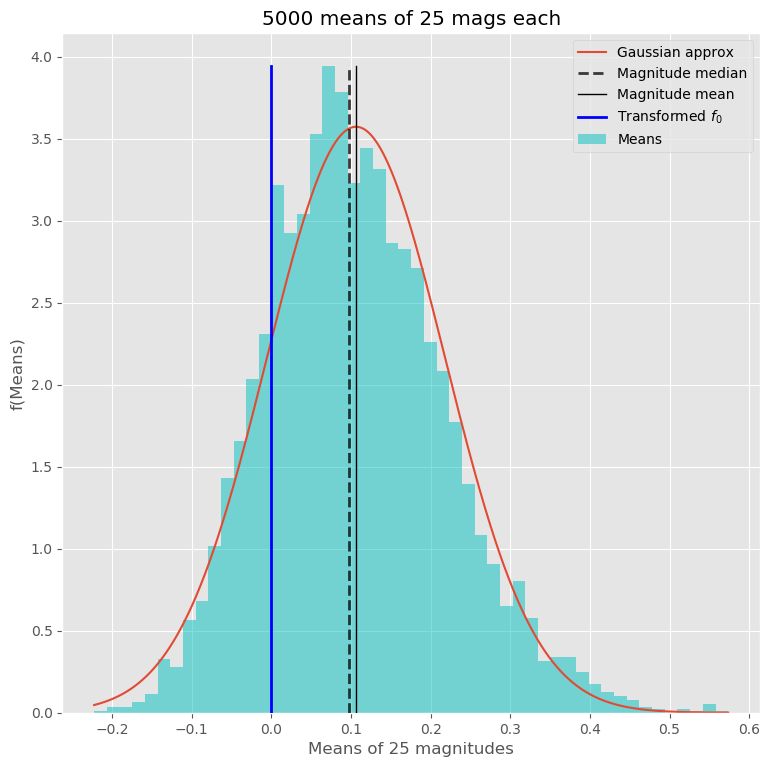

In [13]:
# let's try taking averages and appealing to the central limit theorem. What happens?

print np.size(mag)
nAverages = 5000
nClumps = 25
aDum, vMeans = avgClumps(mag, nClumps,nAverages)

# now do a histogram of THESE
fig2 = plt.figure(2, figsize=(9,9))
fig2.clf()
ax2 = fig2.add_subplot(111)

nAvg, edgesAvg, _ = ax2.hist(vMeans, 50, color='c', normed=True, label='Means', alpha=0.5)

medAv = np.mean(vMeans)
stdAv = np.std(vMeans)

print medAv, stdAv

# next step - overplot the gaussian
magFine = np.linspace(np.min(vMeans), np.max(vMeans), 1000)
dum2 = ax2.plot(magFine, Gauss1d(magFine, medAv, stdAv), label='Gaussian approx')

ySho2 = np.max(nAvg) * 1.

# averaged midpoint
xMeanAvg = np.median(vMeans) * np.array([1., 1.])
plt.plot(xMeanAvg, [0., ySho2], 'k--', zorder=36, lw=2, alpha=0.75, label='Magnitude median')

xMeanMean = np.mean(vMeans) * np.array([1., 1.])
plt.plot(xMeanMean, [0., ySho2], 'k-', zorder=36, lw=1, alpha=1.0, label='Magnitude mean')


# show our transformed mode again
dumMode = ax2.plot([0., 0.], np.array([0., ySho2]), 'b-', lw=2, zorder=35, label='Transformed $f_0$')

leg2 = ax2.legend()

# annotate the plot
ax2.set_title('%i means of %i mags each' % (nAverages, nClumps))
ax2.set_xlabel('Means of %i magnitudes' % (nClumps))
ax2.set_ylabel('f(Means)')

print xSho


So our strategy of averaging has had mixed success. The distribution has indeed been converted to a nice symmetric Gaussian, but our bias is very much still present. And, **unlike** the single-measurement case before, now the median magnitude is also biased (because it is now close to the mean, which was biased high by the long tail in the magnitudes).

This situation might arguably be more dangerous than the pre-averaging situation, since now there is no indication from the distribution of residuals here that anything is amiss (imagine this were the only graph you had been given for this dataset)...

### 1.4. What do we report for $\sigma$(mag)? ###

Clearly, quoting a single number for the distribution of "mag" in this case runs the risk of misleading the reader. If you didn't have the graphs above, the number $\phi \pm \sigma(\phi)$ would lead you to infer the red gaussian overlaid rather than the true underlying distribution, and you would overestimate the likelihood of bright magnitudes and underestimate the faint.

### 1.4.1. Asymmetric errorbars $s_{lo}$, $s_{hi}$- ###

There are a variety of approaches in the literature when reporting asymmetric errors like this. It's common to see numbers like $8.3^{+0.23}_{-0.15}$ without much (or any!) explanation of what those numbers actually mean. 

One good choice is to report the expectation values of $(\phi_{i,+} - \phi_m)^2$ and $(\phi_{i,-} - \phi_m)^2$ for wings in which the points are above and below the midpoint $\phi_m$ respectively. This has the desirable feature that the two values tend to the standard deviation $\sigma(\phi)$ for symmetric distributions.

Here's some analytic justification. The familiar sample variance, $s$, is given by
\begin{eqnarray}
    s^2 & = & \frac{1}{N-1} \sum^{\rm all}_{i=1} \left( x_i - \overline{x} \right)^2 \\
    & = & \frac{1}{N_{\rm hi} - 1} \sum^{x \le \overline{x}}_i \left( x_i - \overline{x} \right)^2 + \frac{1}{N_{\rm lo}} \sum^{x > \overline{x}}_i \left( x_i - \overline{x} \right)^2 \\ 
\end{eqnarray}

\noindent and so one way to report ranges for an asymmetric distribution might be
\begin{eqnarray}
    s^2_{\rm lo} & \equiv & \frac{1}{N_{\rm hi} - 1} \sum^{x \le \overline{x}}_i \left( x_i - \overline{x} \right)^2 \\
    s^2_{\rm hi} & \equiv & \frac{1}{N_{\rm lo}} \sum^{x > \overline{x}}_i \left( x_i - \overline{x} \right)^2 
\end{eqnarray}

In practice, $N_{lo}$~and $N_{hi}$~are usually assumed to be large enough that $N-1 \approx N$~(thus avoiding getting tangled up in questions about where the degree of freedom is being lost).

**WARNING** - we need to be a bit careful what we mean by the "central" point $\overline{x}$. This depends on what the investigator is trying to get across. Some example options, all of which you might see in the literature:
* For consistency with the symmetric behavior, might choose $\overline{x}$ = mean($x$);
* For robustness to outliers, might choose $\overline{x}$ = median($x$);
* To reproduce the transformed distribution, might choose $\overline{x}$ = mode($x$). This puts the center of the bi-gaussian at the peak of the distribution and makes graphs look nicer...

These three options are implemented in the plotting cell below.

The methods below implement some of this. A couple of notes:

Programming notes: "bHi" is a Boolean array which might look like [True, True, False, True, False...]. The syntax "~bHi" means "inverse of bHi", i.e. "not bHi". In Python, np.sum() of a Boolean array returns the number of items that were "True" in the array, which is a convenient way to get $N_{+}$ and $N_{-}$ in the method below.

For large values of flux standard deviation, an asymmetric gaussian is still a poor fit to the actual distribution! 

In [14]:
def ReturnAsymmetricStddevs(x, midpt='blah'):
    
    try:
        xMed = midpt * 1.0
    except:
        xMed = np.median(x) # if not passed in, use the median
    bHi = x >= xMed  # boolean: is the point > median?
    StdHi = np.sqrt(np.sum( (x[bHi] - xMed)**2 ) * 1.0/np.sum(bHi)  )
    StdLo = np.sqrt(np.sum( (x[~bHi] - xMed)**2) * 1.0/np.sum(~bHi) )
    return StdLo, StdHi

In [15]:
# What might we quote? 
midpoint = np.median(mag)
sLo, sHi = ReturnAsymmetricStddevs(mag, midpoint)
print "\r$%.2f^{+%.3f}_{-%.3f}$" % (midpoint, sHi, sLo)

$0.00^{+0.738}_{-0.338}$


For the example above, when I first ran this with median 20., stddev 6.0, the most probable value, upper and lower spreads respectively, were -0.114, 0.501, -0.216. That might be reported as

\begin{equation}
    \hat{m} = -0.11^{+0.501}_{-0.216}
\end{equation}

Let's take a look at what happens when we abut two Gaussians together to approximate the profile:

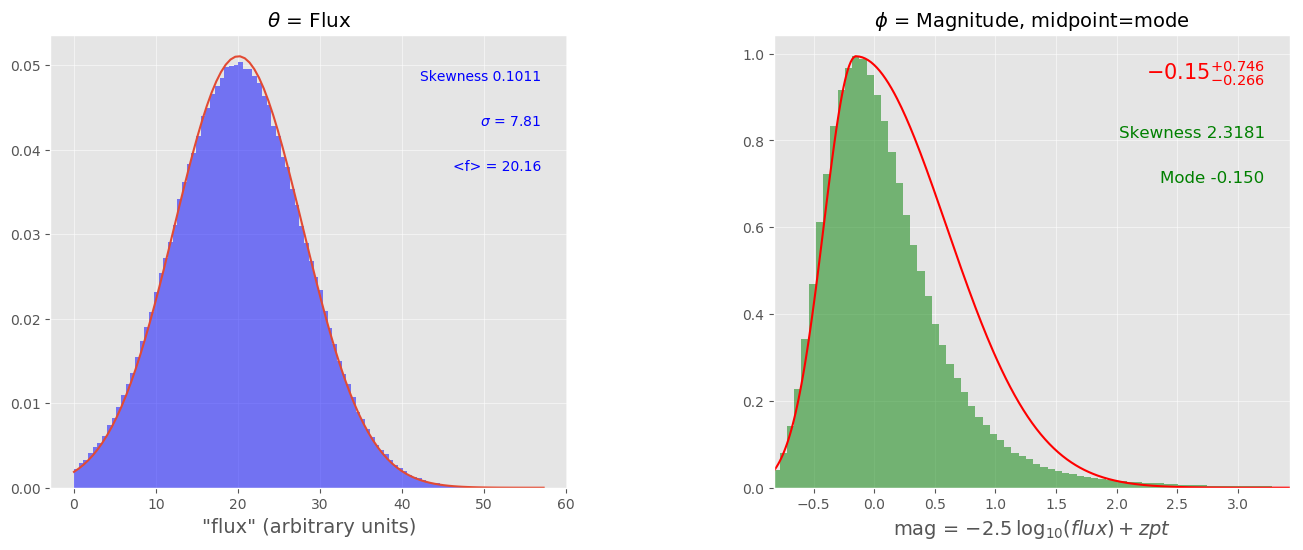

In [16]:
# What choice of midpoint do we use?  (Options: 'median', 'mean', 'mode')
midpointChoice = 'mode'


plt.figure(3, figsize=(16,6))
plt.clf()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.subplot(121)
dum = plt.hist(fl, bins=100, alpha=0.5, normed=True, color='b')
plt.xlabel('"flux" (arbitrary units)', fontsize=14)
plt.grid(which='both', alpha=0.5, zorder=30)

plt.annotate('<f> = %.2f' % (np.mean(fl)), (0.95,0.70), \
             color='b', xycoords='axes fraction', ha='right')


plt.annotate('$\sigma$ = %.2f' % (fluxMoments[0]), (0.95,0.80), \
             color='b', xycoords='axes fraction', ha='right')

plt.annotate('Skewness %.4f' % (fluxMoments[1]), (0.95,0.90), \
             color='b', xycoords='axes fraction', ha='right')

# Let's overplot a gaussian again
xFine = np.linspace(np.min(fl), np.max(fl), num=100)
plt.plot(xFine, Gauss1d(xFine, np.median(fl), np.std(fl) ))
plt.title("$\\theta$ = Flux")

plt.subplot(122)
nMag,magBins,_ = \
    plt.hist(mag, bins=200, alpha=0.5, color='g', normed=True)
plt.grid(which='both', alpha=0.5, zorder=30)
plt.xlabel('mag = $-2.5\/ \log_{10}(flux) + zpt$', fontsize=14)
plt.annotate('Skewness %.4f' % (magnMoments[1]), (0.95,0.80), \
             color='g', xycoords='axes fraction', ha='right', fontsize=12, va='top')
plt.title('$\phi$ = Magnitude, midpoint=%s' % (midpointChoice), fontsize=14)

# Get the mode of the magnitude
#mMode = magBins[np.argmax(nMag)]+0.5*(magBins[1]-magBins[0])
mMode = EstMostProbable(mag)

plt.annotate('Mode %.3f' % (mMode), (0.95,0.70), \
             color='g', xycoords='axes fraction', ha='right', fontsize=12, va='top')

# choice of midpoint?
if midpointChoice.find('edian') > -1:
    central = np.median(mag)
if midpointChoice.find('ean') > -1:
    central = np.mean(mag)
if midpointChoice.find('ode') > -1:
    central = mMode

sLoMag, sHiMag = ReturnAsymmetricStddevs(mag, midpt=central)

# let's try a gaussian here...
xFine = np.linspace(np.min(mag), np.max(mag), num=1000)
bFnHi = xFine >= central
# scale the gaussian so that max(gaussian) meets max(histogram)
gausMultHi = sHiMag * np.sqrt(2.0*np.pi) * np.max(nMag)
gausMultLo = sLoMag * np.sqrt(2.0*np.pi) * np.max(nMag)

    
plt.plot(xFine[bFnHi], \
        gausMultHi * Gauss1d(xFine[bFnHi], central, sHiMag ), \
        color='r')
plt.plot(xFine[~bFnHi], \
         gausMultLo * Gauss1d(xFine[~bFnHi], central, sLoMag ), \
        color='r')


# Zoom in a little on the display to bring out the shape.
# Comment this out to see just how large the range in "mag" really is...
dum = plt.xlim(np.median(mag)-6.0 * np.std(mag), np.median(mag)+6.0 * np.std(mag))

# Create string to annotate
sAnno = '$%.2f^{+%.3f}_{-%.3f}$' % (mMode, sHiMag, sLoMag)
plt.annotate(sAnno, (0.95,0.95), xycoords='axes fraction', color='r',\
            ha='right', fontsize=15, va='top')

if doZoom:
    # use percentiles
    xLims = np.percentile(mag, [0.2, 99.8])
    plt.xlim(xLims[0], xLims[1])
    #plt.ylim(0,1.05)


Compare this with the pair of histograms in Section 1.1 above.

### 1.5. Reporting the residuals-distribution itself ###

Instead of reporting the statistics of the distribution in some way, you might choose to report the distribution itself. How you do this probably depends on the medium in which you are reporting: 

* If you want to produce a physical report someone might print and read, you want to describe the form and parameter values of the curve that describes the distribution. Only plotting the graph complicates the task of the reader should they wish to use the distribution. 

* If you're producing an electronic resource, then you may be able to upload a routine to do it. The example below gives ideas of how you might do this:

In [17]:
SmoothApprox = stats.gaussian_kde(mag)

The above object is now a function that the end-user can use to plot the distribution for any input value. Serializing this object to disk then allows another user to load it and use it with their own inputs should they wish. 

(I don't recommend using gaussian_kde since evaluating the result is quite slow! There are other better implementations out there.)

As an example, we'll plot the magnitude values and this form on top of it. We'll include the magnitude histogram one last time for comparison.  

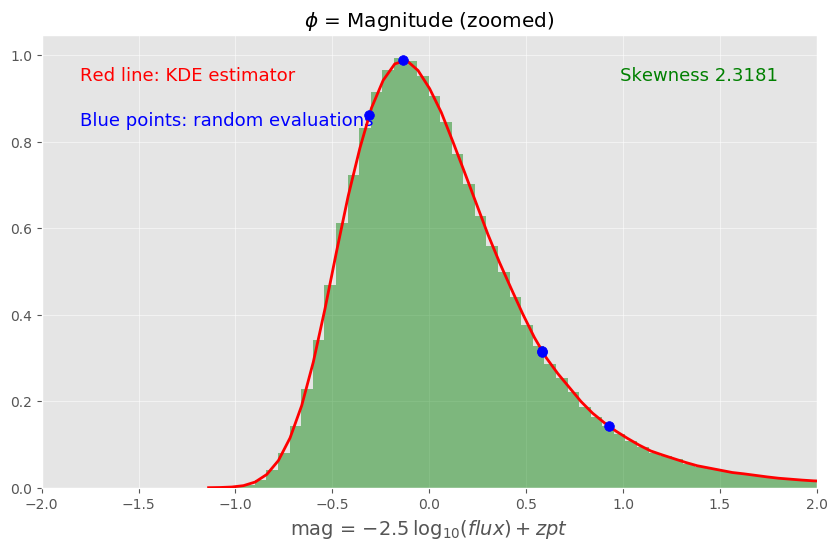

In [18]:
plt.figure(4, figsize=(10,6))
nMag,magBins,_ = \
    plt.hist(mag, bins=200, alpha=0.45, color='g', normed=True)
plt.grid(which='both', alpha=0.5, zorder=30)
plt.xlabel('mag = $-2.5\/ \log_{10}(flux) + zpt$', fontsize=14)
plt.annotate('Skewness %.4f' % (magnMoments[1]), (0.95,0.90), \
             color='g', xycoords='axes fraction', ha='right', \
            fontsize=13)
plt.title('$\phi$ = Magnitude (zoomed)')

plt.annotate('Red line: KDE estimator', (0.05,0.9), \
             xycoords='axes fraction', color='r', \
            ha='left', fontsize=13)

plt.annotate('Blue points: random evaluations', (0.05,0.8), \
             xycoords='axes fraction', color='b', \
            ha='left', fontsize=13)

# fine grid to show the plot. 
xFine = np.linspace(np.min(mag), np.max(mag), 200)
yFine = SmoothApprox(xFine) # This takes a few seconds on my laptop...

# simulate a few user-chosen values
xSim = np.random.uniform(low=-1.0, high=1.0, size=5)
ySim = SmoothApprox(xSim)
plt.plot(xFine, yFine, color='r', lw=2, zorder=10)

plt.xlim(-2,2)

plt.scatter(xSim, ySim, s=49, c='b', zorder=15)